In [14]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [15]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [16]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
!git clone https://github.com/udacity/deep-learning-v2-pytorch.git

Cloning into 'deep-learning-v2-pytorch'...
remote: Enumerating objects: 1078, done.
remote: Total 1078 (delta 0), reused 0 (delta 0), pack-reused 1078
Receiving objects: 100% (1078/1078), 147.91 MiB | 30.76 MiB/s, done.
Resolving deltas: 100% (448/448), done.
Checking out files: 100% (270/270), done.


### **Load in Content and Style Images**




In [17]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [18]:
# load in content and style image
# content = load_image('/content/deep-learning-v2-pytorch/style-transfer/images/octopus.jpg').to(device)
content = load_image('/content/photo_hafeez.jpg').to(device)
content1 = load_image("/content/passport_hafeez.jpg").to(device)
# Resize style to match content, makes code easier
style = load_image('/content/hafeez.jpg', shape=content.shape[-2:]).to(device)
style1=  load_image('/content/delaunay.jpg', shape=content.shape[-2:]).to(device)

In [19]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

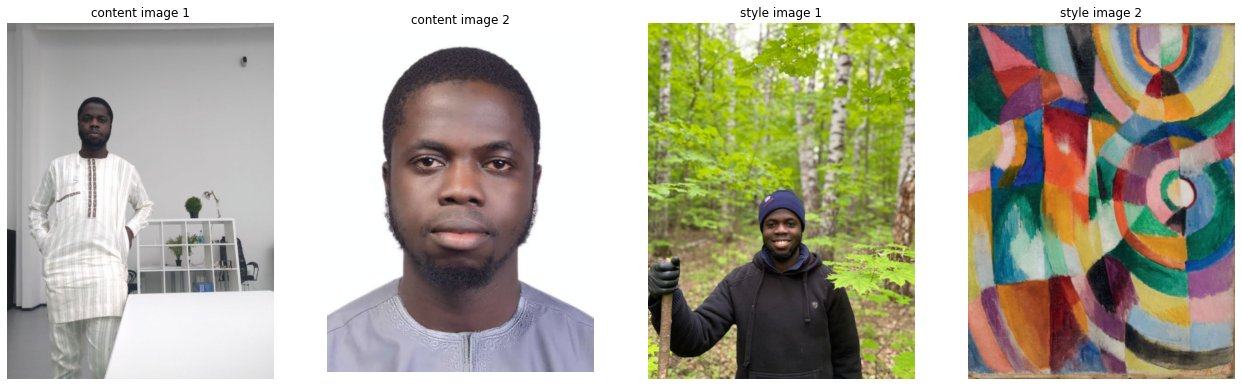

In [22]:
# display the images
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
# content and style ims side-by-side
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax1.title.set_text("content image 1")
ax2.title.set_text("content image 2")
ax3.title.set_text("style image 1")
ax4.title.set_text("style image 2")
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(content1))
ax3.imshow(im_convert(style))
ax4.imshow(im_convert(style1))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [ ]:
# print out VGG19 structure so you can see the names of various layers
# print(vgg)

## Content and Style Features

#### TODO: complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

The first layer (0) to `conv1_1` has been done for you, below.

In [23]:
def get_features(image, model, layers=None):

    if layers is None:
        layers = {'0': 'conv1_1', 
                  "5":"conv2_1",
                  "10":"conv3_1",
                  "19":"conv4_1",
                  "21":"conv4_2",
                  "28":"conv5_1"}
             
    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size()`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 

*Note: You can multiply two matrices using `torch.mm(matrix1, matrix2)`.*

#### TODO: Complete the `gram_matrix` function.

In [24]:
def gram_matrix(tensor):

    _, depth, width, height = tensor.size()
    
    tensor = tensor.view(depth, height*width)


    gram = torch.mm(tensor, tensor.t())
  
    return gram 

In [21]:
# target_features = get_features(target, vgg)
# content_features = get_features(content, vgg)
# cccc=torch.mean(content_features["conv1_1"])
# plt.imshow(im_convert(cccc))
# cccc

tensor(0.2710, device='cuda:0')

## Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

---
## Loss and Weights

#### Individual Layer Style Weights

Below, you are given the option to weight the style representation at each relevant layer. It's suggested that you use a range between 0-1 to weight these layers. By weighting earlier layers (`conv1_1` and `conv2_1`) more, you can expect to get _larger_ style artifacts in your resulting, target image. Should you choose to weight later layers, you'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

#### Content and Style Weight

Just like in the paper, we define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [25]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}
# you may choose to leave these as is
content_weight = 1  # alpha
style_weight = 1e6  # beta

In [30]:
def contentloss(content, target):
    target_features = get_features(target, vgg)
    content_features = get_features(content, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)    
    return content_loss

def transfer_style(content, style, show_every, steps):
  content_features = get_features(content, vgg)
  style_features = get_features(style, vgg)
  losses = []
  targets=[]
  fig, (ax) = plt.subplots(1, 4, figsize=(20, 10))
  ind=0

  # calculate the gram matrices for each layer of our style representation
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

  target = content.clone().requires_grad_(True).to(device)
  optimizer = optim.Adam([target], lr=0.003)  
  for ii in range(1, steps+1):
      ## TODO: get the features from your target image    
      ## Then calculate the content loss
      target_features = get_features(target, vgg)
      content_loss = contentloss(content, target)
      style_loss = 0
      for layer in style_weights:
          # get the "target" style representation for the layer
          target_feature = target_features[layer]
          
          _, d, h, w = target_feature.shape
          
          # Calculate the target gram matrix
          target_gram = gram_matrix(target_features[layer])
          
            # get the "style" style representation
          style_gram = style_grams[layer]
          ##  Calculate the style loss for one layer, weighted appropriately
          layer_style_loss = torch.mean((target_gram - style_gram)**2)    
          
          # add to the style loss
          style_loss += layer_style_loss / (d * h * w)
          
          
      ##  calculate the *total* loss
      total_loss =style_loss+ content_loss
      losses.append(total_loss.item())
      ## -- do not need to change code, below -- ##
      # update your target image
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      # fig, axs = plt.subplots(nrows=1, ncols=2)
      # display intermediate images and print the loss
      if  ii  % show_every == 0:
        # ax[ind].axis(off)
        ax[ind].axis('off')
        ax[ind].imshow(im_convert(target))
        ind+=1
  return target, losses 
# transfer_style(content, target)
# target, target_loss=transfer_style(content, style, 25, 100)

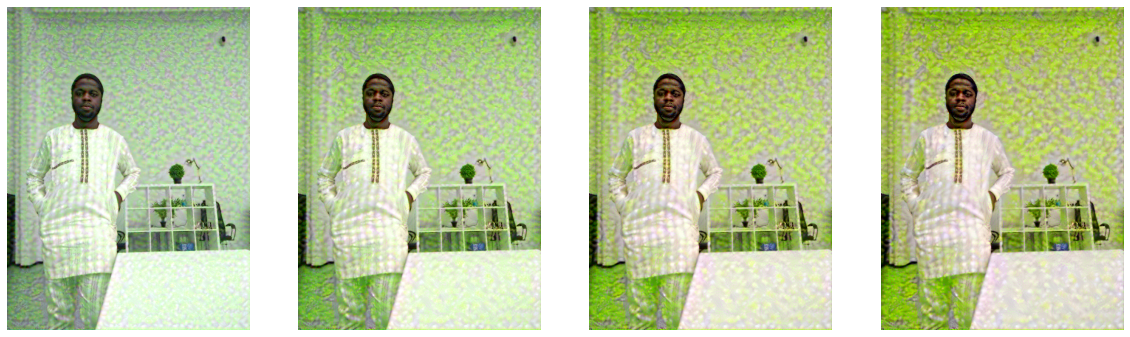

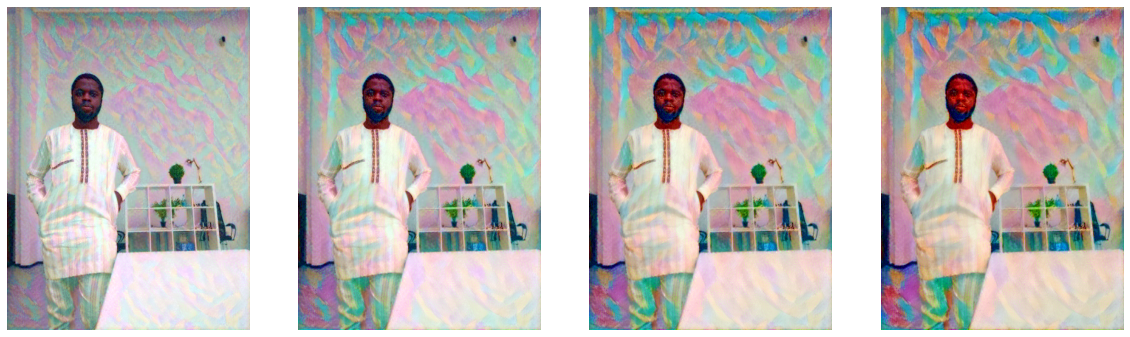

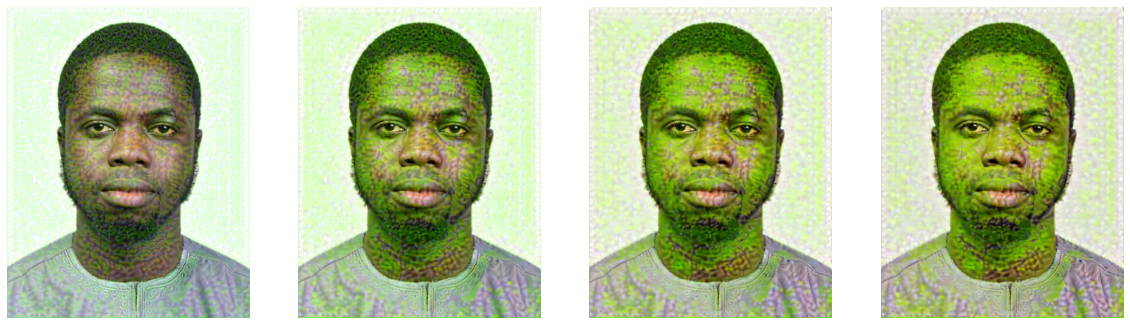

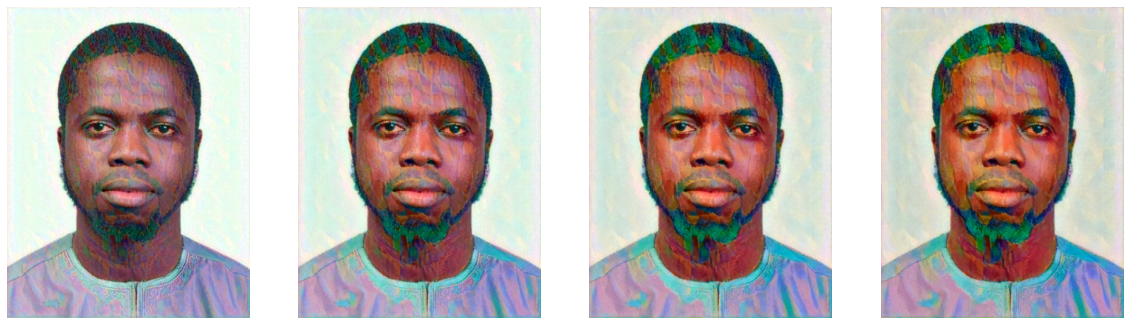

In [31]:
target, target_loss=transfer_style(content, style, 400, 1600)
# plt.plot(target_loss1)
target1, target_loss1=transfer_style(content, style1, 400, 1600)
target2, target_loss2=transfer_style(content1, style, 400, 1600)
target3, target_loss3=transfer_style(content1, style1, 400, 1600)

# target1=tdransfer_style(content1, style, 400, 2000)
# target2=transfer_style(content1, style1, 400, 2000)
# target3=transfer_style(content, style1, 400, 2000)

In [25]:
target_loss1

[140.12594604492188]

## Display the Target Image

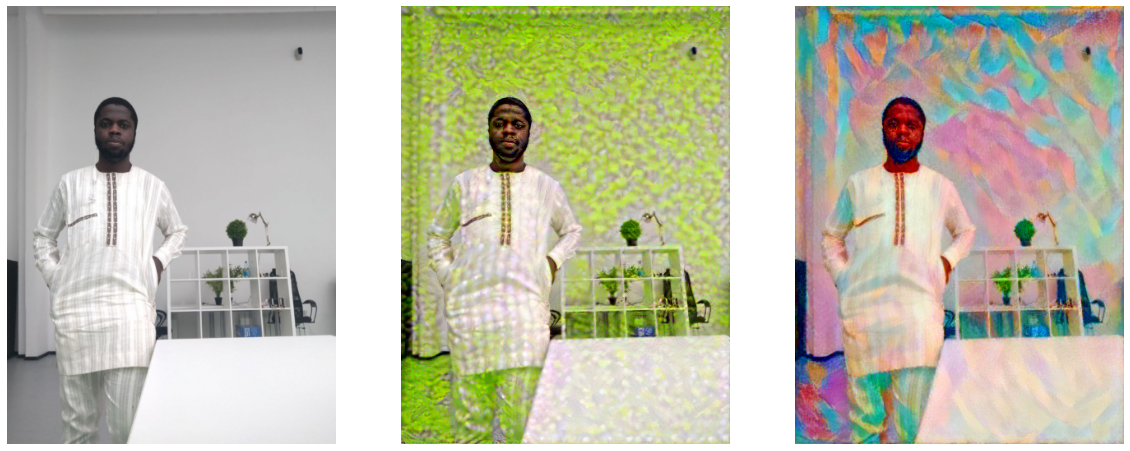

In [52]:
# display content and final, target image
# import matplotlib.gridspec as gridspec

# gs1 = gridspec.GridSpec(20, 10)
# gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.axis('off')
ax1.axis('off')
ax3.axis('off')
ax2.imshow(im_convert(target))
ax3.imshow(im_convert(target1))

# plt.subplots_adjust(wspace=0, hspace=0)


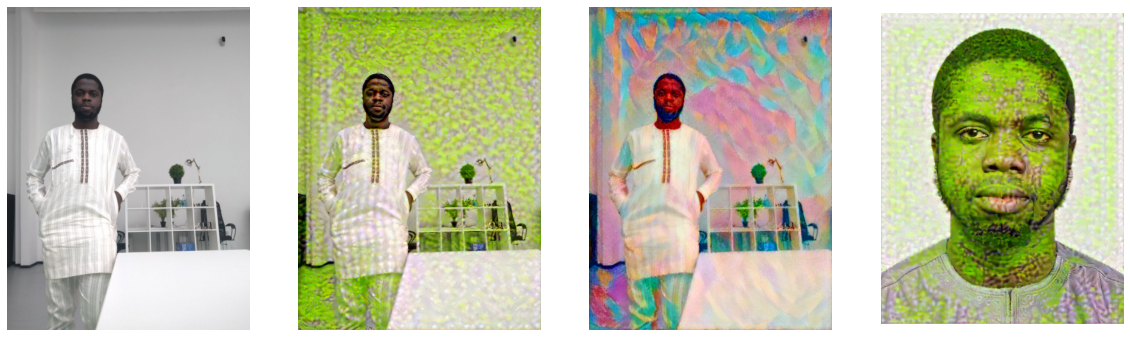

In [53]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.axis('off')
ax1.axis('off')
ax3.axis('off')
ax4.axis('off')
ax2.imshow(im_convert(target))
ax3.imshow(im_convert(target1))
ax4.imshow(im_convert(target2))


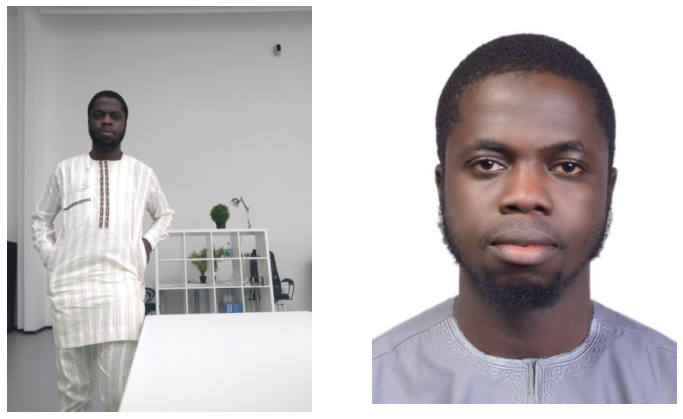

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(im_convert(content))
ax2.axis('off')
ax1.axis('off')
# ax3.axis('off')
# ax4.axis('off')
ax2.imshow(im_convert(content1))
# ax3.imshow(im_convert(target1))
# ax4.imshow(im_convert(target2))


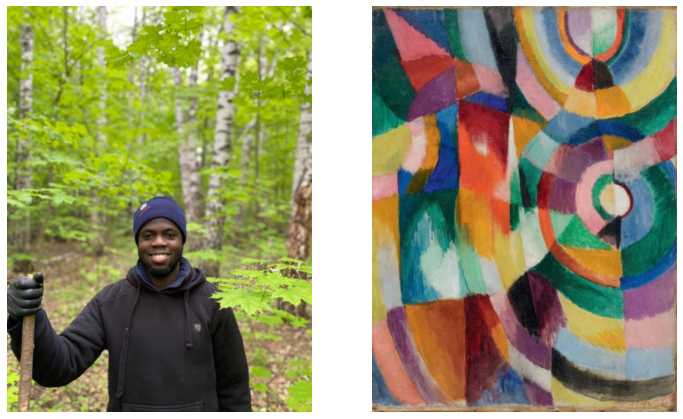

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.imshow(im_convert(style))
ax2.axis('off')
ax1.axis('off')
# ax3.axis('off')
# ax4.axis('off')
ax2.imshow(im_convert(style1))

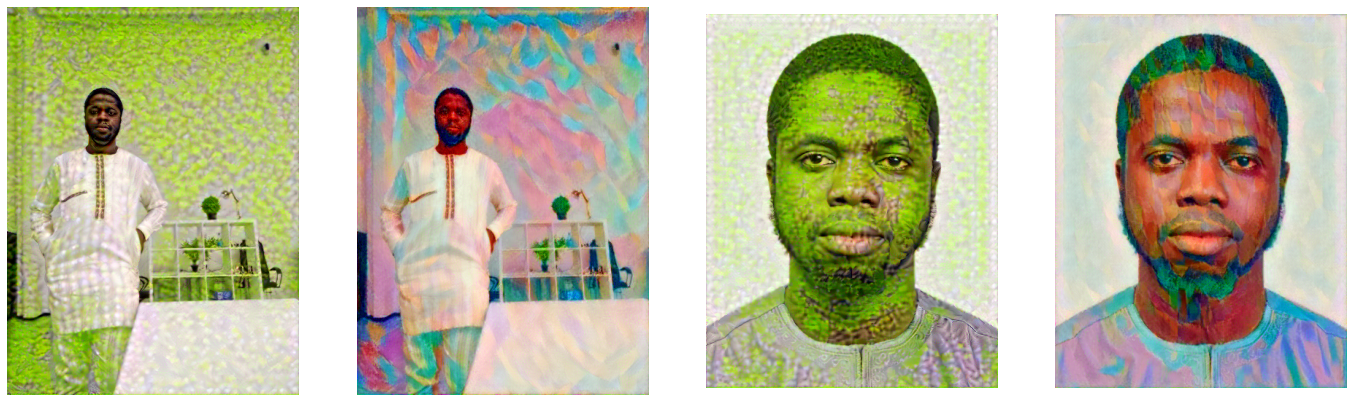

In [54]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 8))
ax1.imshow(im_convert(target))
ax2.axis('off')
ax1.axis('off')
ax3.axis('off')
ax4.axis('off')
ax2.imshow(im_convert(target1))
ax3.imshow(im_convert(target2))
ax4.imshow(im_convert(target3))

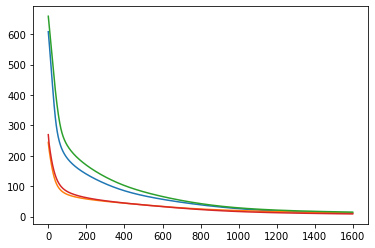

In [58]:
plt.plot(target_loss)
# plt.show()
plt.plot(target_loss1)
# plt.show()
plt.plot(target_loss2)
# plt.show()
plt.plot(target_loss3)
plt.show()

